In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import namedtuple
from IPython.display import display, HTML
import io, base64

In [2]:

def check_tax_schedule(b,r):
    check = """The tax schedule you submitted fails to meet one of these requirements: \n
    1. b[0] must equal 0
    2. b and r must have the same length 
    3. b must be monotonically increasing"""
    if not len(b) == len(r):
        return check

    if not b[0] == 0:
        return check

    b_diff = [b[j+1] - b[j] for j in range(len(b)-2)]
    for diff in b_diff:
        if diff <= 0:
            return check
    return ""

def ar(y, b, r):
    # change to brackets, rates
    """
    Calculates the average tax rate for a firm. 

    Inputs
    -----------
    y, digital advertising revenue for a firm 
    b, a list of tax brackets
    r, a corresponding list of tax rates 
    
    Output
    -------
    The average tax rate 
    """
    # index the elements of b 
    ind = {}
    for m, l in enumerate(b):
        ind[l] = m

    # calculate the tax on edges -- t_on_e: 
    #     tax due when revenue is equal to one of the elements of b
    #     that are the edges of the brackets.

    t_on_e = {}
    for edge in b:
        if edge == 0:
            t_on_e[edge] = 0
        else:
            t_on_e[edge] = (
                ( b[ind[edge]] - b[ind[edge]-1] ) * r[ind[edge]-1] +
                t_on_e[b[ind[edge]-1]] )
    
    # calculate the average tax rate a
    if y == 0:
        a = 0 
        
    for j in range(len(b)-1):
        if b[j] < y and y <= b[j+1]:
            a = ( (y - b[j]) * r[j] + t_on_e[b[j]] ) / y
    
    if  y > b[-1]:
        a = ( (y - b[-1]) * r[-1] + t_on_e[b[-1]] ) / y 
    
    return a

def split(y, m, b, r):
    """[summary]

    Parameters
    ----------
    y:float -- revenue of the initial firm
    m:int -- number of successor firms of equal size 
    b:float -- brackets
    r:float -- marginal rates 

    Output
    ------
    float -- total tax owed by the m successor firms 
    """
    return ar(y/m, b, r) * y

def us_firms():
    """
    Returns a list and an ndarray.
    The elements of the list are namedtuples, one for each firm. 
    Each of this has elements .name and .US_revenue.
        US_revenue is itself a namedtuple with elements "yr_2018" ... "yr_2023". 
    For code the refers to specific years, the namedtuples are more readable. 
    The 13 by 6 ndarray has revenue for firms (rows) and years (columns).
    """
    us_firms_d = {
        'Amazon': [7.41, 10.32, 15.73, 20.47, 26.2, 31.97],
        'Facebook': [24.52, 31.27, 38.3, 48.48, 57.06, 65.38],
        'Google': [36.48, 41.8, 44.06, 54.93, 60.7, 66.47],
        'Hulu': [1.46, 1.95, 2.55, 3.39, 4.17, 4.98],
        'IAC': [0.5, 0.62, 0.55, 0.6, 0.64, 0.67],
        'Microsoft': [4.56, 5.29, 5.56, 6.65, 7.51, 8.3],
        'Reddit': [0.08, 0.1, 0.18, 0.25, 0.32, 0.37],
        'Roku': [0.29, 0.53, 0.83, 1.46, 2.06, 2.74],
        'Snapchat': [0.67, 0.88, 1.25, 1.82, 2.5, 3.33],
        'Spotify': [0.36, 0.45, 0.52, 0.7, 0.87, 1.03],
        'Twitter': [1.32, 1.6, 1.7, 2.21, 2.56, 2.75],
        'Verizon Media': [3.45, 3.36, 3.18, 3.44, 3.64, 3.79],
        'Yelp': [0.89, 0.96, 0.83, 0.92, 1.01, 1.07]
        }

    # namedtuple for revenue
    US_revenue = namedtuple(
        "US_revenue", 
        ["yr_2018", "yr_2019", "yr_2020", "yr_2021", "yr_2022", "yr_2023"]
        )
    firms = []

    # namedtuple for a firm
    Firm_nt = namedtuple("Firm_nt", ["name", "us_rev"])
    for k, v in us_firms_d.items():
        firms.append(Firm_nt(k, US_revenue(*[rev for rev in v])))
    
    # firms_sorted is a list of namedtuples sorted by revenue in 2020
    firms_sorted:list = sorted(
        firms, key=lambda firm: firm.us_rev.yr_2020, reverse = True
        )
    rev_firm_year = np.zeros((13,6), dtype = float)
    for r in range(13):
        rev_firm_year[r] = np.array([firms_sorted[r][1]])
    return firms_sorted, rev_firm_year

def table_marg_rates(b, r):
    bl = b
    bu = (b[1:] + [np.inf])

    row_list = []
    row_list.append(
        f" Revenue Between " + " " * 3 + "Marginal Rate" + " " * 0
        )

    for j in range(len(b)):
        l = b[j]
        u = bu[j]
        t = r[j]
        if u == np.inf:
            row_list.append(
                " " * 0 + f"Above{l:>3} billion {t:>12.1%}" + " " * 4
                )
        else:
            row_list.append(
                " " * 0 + f" {l:>2} - {u:>2} billion {t:>12.1%}" + " " * 4
                )
            
    # for row in row_list:
    #     print(len(row))
    #     print(row)

    return h_table(
        row_list, font_size=12, row_margin = "4px",
        display_html = False, return_html = True
        )
        

def calc_avg_rates(rev, b, r):
    avg_rate = np.zeros((13,6), dtype = float)
    for row in range(13):
        for col in range(6):
            avg_rate[row,col] = ar(float(rev[row,col]), b, r)
    return avg_rate


def table_revenue(b, r):
    _, rev = us_firms()
    total_rev_by_year = rev.sum(0)
    google_rev = rev[0]
    google_tax = [ar(y, b, r)*y for y in google_rev]
    facebook_rev = rev[1]
    facebook_tax = [ar(y, b, r)*y for y in facebook_rev]
    avg_rate = calc_avg_rates(rev, b, r)
    tax_owed = (rev * avg_rate).sum(0)

    row_list = []

    row_list.append(f"{'Revenue (billions)': ^30}")
    row_list.append("Year  Industry Google Facebook")

    for j in range(6): 
        row = f"{2018+j: ^4d}{total_rev_by_year[j]: >8.1f}{google_rev[j]: >8.1f}"
        row += f"{facebook_rev[j]: >8.1f}{' '}"
        row_list.append(row)
        

    return h_table(
        row_list, header_rows = 2, font_size=12,
        row_margin = "4px", display_html = False, return_html = True
    )  

def table_tax(b, r):
    _, rev = us_firms()
    total_rev_by_year = rev.sum(0)
    google_rev = rev[0]
    google_tax = [ar(y, b, r)*y for y in google_rev]
    facebook_rev = rev[1]
    facebook_tax = [ar(y, b, r)*y for y in facebook_rev]
    avg_rate = calc_avg_rates(rev, b, r)
    tax_owed = (rev * avg_rate).sum(0)
    
    row_list = []
    row_list.append(f"{'Tax Owed (billions)': ^30}")
    row_list.append("Year  Industry Google Facebook")
    
    for j in range(6): 
        row = f"{''}{2018+j: ^4d}{tax_owed[j]: >8.1f}"
        row += f"{google_tax[j]: >8.1f}{facebook_tax[j]: >8.1f}{'  '}"
        row_list.append(row)

    return h_table(row_list, header_rows = 2, font_size=12,
                   row_margin = "4px", display_html = False, return_html = True
                  )  



##############################################################################
################################# graphs #####################################
##############################################################################

base_style = {
    # In a notebook, higher dpi makes the graph larger
    'figure.dpi':                   300,   
    'figure.figsize':  [3*1.6180339, 3],  
    'figure.facecolor':         'white',
    # Default font sizes need to be smaller with higher dpi
    'figure.titlesize':               8,
    'axes.titlesize':                 8, 
    'axes.labelsize':                 6,
    'ytick.labelsize':                5,
    'xtick.labelsize':                5,
    'legend.fontsize':                5,
    'lines.linewidth':                1,
    'lines.markersize':               3,
    'xtick.major.size':             2.0,
    'xtick.major.width':            0.3,
    'ytick.major.size':             2.0,
    'ytick.major.width':            0.3,
}

def floating_spines(ax, axis = 'l'):
    """[summary]

    Parameters
    ----------
    ax : [type]
        [description]
    axis : str, optional
        [description], by default 'l'

    Returns
    -------
    [type]
        [description]
    """
    ax.spines['top'].set_visible(False)
    if axis == 'l':
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['left'].set_linewidth(0.2)
        ax.spines['left'].set_position(('outward', 5))
    else:
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(True)
        ax.spines['right'].set_linewidth(0.2)
        ax.spines['right'].set_position(('outward', 5))

    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_linewidth(0.2)
    ax.spines['bottom'].set_position(('outward', 5))
    return ax


def us_fig(b: list, r: list):
    """
    """
    firms, _ = us_firms()
    # avg_rate = calc_avg_rates(rev)

    names = [firm.name for firm in firms]
    rev_2021 = [firm.us_rev.yr_2021 for firm in firms]
    avg_rate_2021 = [ ar(firm.us_rev.yr_2021, b, r) for firm in firms]
    tax_paid_2021 = np.array(
        [ar(firm.us_rev.yr_2021, b, r) * firm.us_rev.yr_2021 for firm in firms]
    )

    rev_for_line = range(60)
    ar_for_line = [ar(x, b, r) for x in rev_for_line]
    
    adjustments = [
            (+0.5, -4, "\nTax = $"+format(tax_paid_2021[0], "<3.1f"), 0),
            (+0.5, -4, "\nTax = $"+format(tax_paid_2021[1], "<3.1f"), 1),
            (+0.5, -4, "\nTax = $"+format(tax_paid_2021[2], "<3.1f"), 2),
            (+1.0, -1, ": Tax = $"+format(tax_paid_2021[3], "<3.1f"), 3),
            (+2.0, -6, "All others: " + "$"+format(tax_paid_2021[4:].sum(), "<3.1f"), 4)
        ]
    
    with plt.style.context(base_style):
        fig = plt.figure()
        ax = fig.add_axes([0.1, 0.15, 0.8, 0.75])
        ax = floating_spines(ax)
        ax.set_xlim(-1, 60)
        ax.set_ylim(-0.01, 0.5)
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1.0, decimals = 0))
        ax.spines['left'].set_bounds(low = 0, high = 0.5)
        ax.spines['bottom'].set_bounds(low = 0, high = 60)
        ax.plot(rev_for_line, ar_for_line)
        ax.plot(rev_2021, avg_rate_2021, ls = '', marker = 'o', ms = 1.5)
        for j in range(len(adjustments)-1):
            ax.text(
                rev_2021[j] + adjustments[j][0], 
                avg_rate_2021[j] + adjustments[j][1]/100, 
                names[j] + adjustments[j][2], fontsize = 4
            ) 
        
        ax.set_title("Average Tax Rate, Total Revenue, and Tax Owed", pad = 10)
        ax.axes.xaxis.set_label_text(
            "Projected US Digital Ad Revenue for 2021 (billion USD)"
        )

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_str = 'data:image/png;base64,' + base64.b64encode(buf.read()).decode('UTF-8')
    #fig.savefig("../graphs/fig-us-default.png")   
    return img_str

def ww_fig(b,r):
    """
    """
    ww_rev_for_graph = range(150)
    ww_ar_for_graph = [ar(x, b, r) for x in ww_rev_for_graph]
    
    # ww revenue for 2021
    ww_rev = {'Amazon': 26.31,
         'Facebook': 107.72,
         'Google': 130.15,
         'IAC': 0.73,
         'Microsoft': 8.96,
         'Reddit': 0.26,
         'Snapchat': 3.21,
         'Spotify': 1.1,
         'Twitter': 4.03,
         'Verizon Media': 4.59,
         'Yelp': 0.93}

    ww_rev_l = list(ww_rev.items())
    ww_rev_sorted = sorted(ww_rev_l, key=lambda firm: firm[1], reverse = True)
    ww_names = [ firm[0] for firm in ww_rev_sorted ]
    ww_rev_2021 = [ firm[1] for firm in ww_rev_sorted ]
    ww_avg_r = [ ar(y, b, r) for y in ww_rev_2021]
    ww_tax_paid = [ar(y, b, r) * y  for y in ww_rev_2021]
    
    adjustments = [
        (+1, -4, "\n $"+format(ww_tax_paid[0], "<3.1f"), 0),
        (+1, -4, "\n $"+format(ww_tax_paid[1], "<3.1f"), 1),
        (+1.5, -4, "\n $"+format(ww_tax_paid[2], "<3.1f"), 2),
       (+2.0, -2, "All others", 3)
    ]
    with plt.style.context(base_style):
        fig = plt.figure()
        ax = fig.add_axes([0.1, 0.15, 0.8, 0.75])
        ax = floating_spines(ax)
        ax.set_xlim(-1, 160)
        ax.set_ylim(-0.01,0.5)
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1.0, decimals = 0))
        ax.spines['bottom'].set_bounds(low = 0, high = 160)
        ax.spines['left'].set_bounds(low = 0, high = 0.5)
        ax.plot(ww_rev_for_graph, ww_ar_for_graph)
        ax.plot(ww_rev_2021, ww_avg_r, ls = '', marker = 'o', ms = 1.5)
        for j in range(len(adjustments)-1):
            ax.text(
                ww_rev_2021[j] + adjustments[j][0],
                ww_avg_r[j] + adjustments[j][1]/100, 
                ww_names[j] + adjustments[j][2], 
                fontsize = 4
            )

        ax.set_title("Average Tax Rate, Worldwide Revenue, Tax Owed", pad = 10)
        ax.axes.xaxis.set_label_text(
            "Projected Worldwide Digital Ad Revenue for 2021 (billion USD)"
        )
            
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_str = 'data:image/png;base64,' + base64.b64encode(buf.read()).decode('UTF-8')
    #fig.savefig("../graphs/fig-ww-default.png")
    return



##############################################################################
################################# h_table ####################################
##############################################################################



def h_table(
    rows: list,
    has_header: bool = True,
    header_rows: int = 1,
    dark_header: bool = False,
    header_color: str = "#ffffff",
    font_size:int = 16,
    row_margin: str = "2px",
    header_border_bottom: bool = True,
    body_border_bottom: bool = True,
    table_title: str = "",
    table_align: str = "center",
    table_border_all: bool = False,
    border_thickness: str = "1px",
    border_color: str = "Black",
    stripe: bool = True,
    stripe_intensity: float = 0.05,
    display_html:bool = True,
    return_html: bool = False,
    show_args: bool = False,
):

    """
    ---------------------------------------------------------------------------
    htable() takes a list of rows, each of which is a string.

    In the typical use case, these rows will be generated by kw_format(),
        which calls kw_f1().

    The keyword arguments other than the list of rows determine the html
        formatting applied to the rows.

    htable() applies the implied CSS styles inline so the table can be included
        in an html page without knowing what styles it is using and without
        changing its styles.

    Use 'show_args = True' to see all the keyword arguments that determine the
        style of the table.

    The default value for dark_header is false. In this case, the font color
        for the header is black.

    If 'dark_header = True', the font color for the header switches to white
        and the tinted stripes start on row 2 of the body instead of row 1 of
        the body.
    ---------------------------------------------------------------------------

    """
    htable_arg_dict = {
        "has_header": has_header,
        "header_rows": header_rows,
        "dark_header": dark_header,
        "header_color": header_color,
        "font_size": font_size,
        "row_margin": row_margin,
        "header_border_bottom": header_border_bottom,
        "body_border_bottom": body_border_bottom,
        "table_title": table_title,
        "table_align": table_align,
        "table_border_all": table_border_all,
        "border_thickness": border_thickness,
        "border_color": border_color,
        "stripe": stripe,
        "stripe_intensity": stripe_intensity,
        "display_html": display_html,
        "return_html": return_html,
        "show_args": show_args,
    }
    if show_args:
        print("'show_args = True' returns a dictionary of argument names and values,")
        print("    and prints the arguement names and values.")
        print()
        print("In both cases, the results reflect any supplied arguments and")
        print("    any defaults that have not been overwritten.")
        print()
        for key, value in htable_arg_dict.items():
            print(key, " = ", repr(value))
        return htable_arg_dict

    # Create strings for HTML styles
    #   If dark_header, calculate light version of header background for stripe
    if dark_header:
        header_bkgd = "background: " + header_color + ";"
        h_font_color = "color: #ffffff;"
        if stripe:
            stripe_bkgd = "background: " + tint(header_color, stripe_intensity) + "; "
        even_stripes = True

    else:  # default gray
        header_bkgd = "background: #ffffff; "
        h_font_color = "color: #000000; "
        if stripe:
            default_grey = tint("#f5f5f5", stripe_intensity / 0.05)
            stripe_bkgd = "background: " + default_grey + "; "
        even_stripes = False

    #   Font Size
    # table_style = "font-family: Menlo, Courier; "
    table_style = "font-size: " + str(font_size) + "px; "

    #   Borders
    border_style = border_thickness + " solid " + border_color

    if body_border_bottom:
        table_border_style = "border-bottom: " + border_style + "; "
        table_border_style += "border-collapse: collapse; "
    else:
        table_border_style = "border-bottom: none; "

    if table_border_all:
        table_border_style = "border: " + border_style + "; "
        table_border_style += "border-collapse: collapse; "

    table_style += table_border_style
    if table_align == "left":
        table_style += 'align="left";'
    else:
        table_style += "margin: 32px; margin-left: auto; margin-right: auto; "

    if header_border_bottom:
        header_style = "border-bottom: " + border_style + "; "
    else:
        header_style = "border-bottom: none; "

    #   Creating the table
    #       add the header row created with header_f()
    #       create header with h_row as input
    #       loop through generator to create b_row and append to b_rows
    #       run body_tags using b_rows as input
    #       run table_tags with header and body as input

    #   Defin local variables
    b_rows = ""

    #   Define functions for creating
    #       table_f -> table tags
    #       header_f -> header tags and header content
    #       body_f -> body tags
    #       body_row_f -> body row tags

    
    font_fam = 'font-family: Menlo, "Deja Vu Sans Mono", "Roboto Mono", "Courier New", '
    font_fam += 'Courier, monospace;'

    def table_f(header, body):
        h = '<table style="{0}">\n'.format(table_style)
        h += "{0}\n".format(header)
        h += "{0}\n".format(body)
        h += "</table>\n"
        return h

    def title_f():
        title_font_size = str(1.5 * font_size)
        title_style = "text-align: center; margin-bottom: " + title_font_size + "px; "
        title_style += "font-size: " + title_font_size + "px; "
        pre_style = font_fam + "{0}{1}{2}".format(
            header_bkgd, h_font_color, title_style
        )
        return pre_style

    def header_f(table_title):
        pre_style = font_fam + "{0}{1}".format(header_bkgd, h_font_color)
        h = '  <thead style="{0}">\n'.format(header_style)
        h += '    <tr style="{0}">\n'.format("")
        h += '      <th style="{0}">\n'.format(header_bkgd)
        if len(table_title) > 0:
            h += "        <pre style='margin: " 
            h += row_margin + "; {0}'>{1}</pre>\n".format(title_f(), table_title)
        for j in range(0,header_rows):
            h += "        <pre style='margin: " 
            h += row_margin + "; {0}'>{1}</pre>\n".format(pre_style, next(row_gen))
        h += "      </th>\n"
        h += "    </tr>\n"
        h += "  </thead>\n"
        return h

    def body_f(b_rows):
        h = "  <tbody>\n{0}\n".format(b_rows)
        h += "  </tbody>\n"
        return h

    def body_row_f(b_row, row_num, even_stripes):
        if even_stripes:
            if row_num % 2 == 0:
                bkgd = stripe_bkgd
            else:
                bkgd = "background: #ffffff; "
        else:
            if row_num % 2 == 0:
                bkgd = "background: #ffffff; "
            else:
                bkgd = stripe_bkgd

        pre_style = font_fam + "{0}".format(bkgd)

        h = "    <tr>\n"
        h += '      <td style="{0}">\n'.format(bkgd)
        h += "        <pre style='margin: " 
        h += row_margin + "; {0}'>{1}</pre>\n".format(pre_style, b_row)
        h += "      </td>\n"
        h += "    </tr>\n"
        return h, row_num + 1

    row_gen = (elem for elem in rows)

    #   Create a generator, build header, remove final newline
    if header_rows > 0 or len(table_title) > 0:
        header = header_f(table_title)[0:-1]
        row_num = 1
    else:
        header = ""
        row_num = 0

    # if header_rows % 2 == 0:
    #     even_stripes = False

    #   Iterate through remaining elements in the generator
    #      Create the string of body rows
    for elem in row_gen:
        h_row, row_num = body_row_f(elem, row_num, even_stripes)
        b_rows += h_row
    body = body_f(b_rows[0:-1])[0:-1]

    #   Create the table from header and body
    table1 = table_f(header, body)
    # table = '<div style="overflow-x:auto;">\n'
    table = "<div>\n"
    table += table1
    table += "</div>"

    if display_html:
        display(HTML(table))

    if return_html:
        return table
    else:
        return


# ===================================================================================
#  Color functions
# ===================================================================================


def shrink_dist_to_max(h, frac):
    return int(frac * h + (1 - frac) * 0xFF)


def tint(color, frac):
    """tint() takes a color as input, returns a tint that is
            only frac times the distance from white of color

       Inputs:
            color is a string in html form for hex representation
                starts w "#" followed by hex digits;
                e.g. "#0000ff" for blue
            frac is a float between 0 and 1
                closer to zero yields a lighter tint

       Return value:
            a string in the same form
            represents a tint that takes the original distance
                of color from white and reduces it to a value of size
                frac
    """
    r = shrink_dist_to_max(int(color[1:3], 16), frac)
    g = shrink_dist_to_max(int(color[3:5], 16), frac)
    b = shrink_dist_to_max(int(color[5:7], 16), frac)
    return "#" + hex((r * 0x10000) + (g * 0x100) + b)[2:]


In [3]:
b = [0,    5,    10,   15,    20,   25,    30,   35,    40,   50,    60]
r = [0, 0.05, 0.125, 0.20, 0.275, 0.35, 0.425, 0.50, 0.575, 0.65, 0.725]

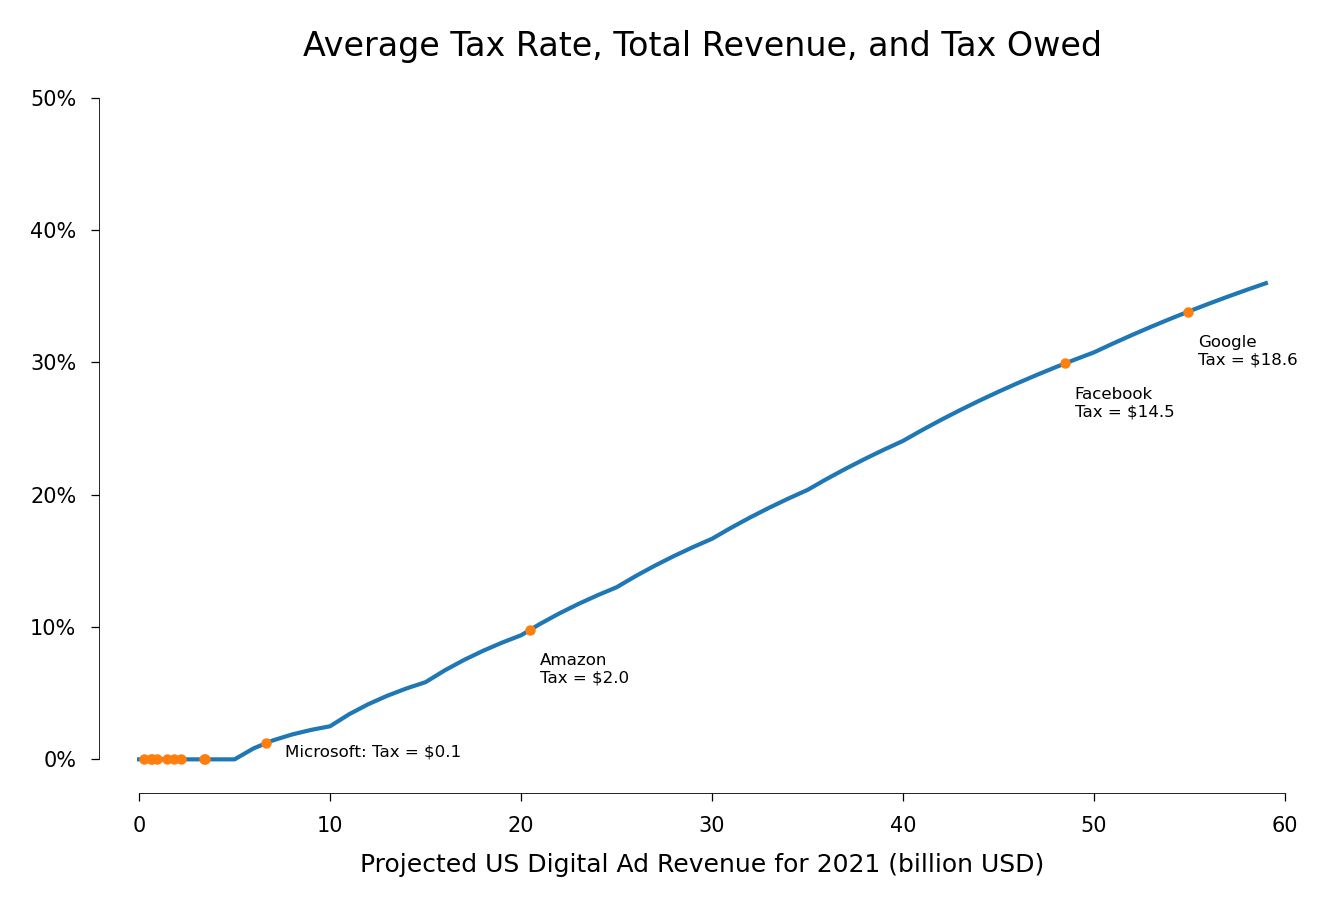

In [4]:
table_marg_rates_result = table_marg_rates(b, r)
table_revenue_result = table_revenue(b, r)
table_tax_result = table_tax(b, r)   
us_fig_result = us_fig(b, r)
split_1_result = split(50, 1, b, r)
split_2_result = split(50, 2, b, r)

In [5]:
display(HTML(table_marg_rates_result))

Revenue Between Marginal Rate
0 - 5 billion 0.0%
5 - 10 billion 5.0%
10 - 15 billion 12.5%
15 - 20 billion 20.0%
20 - 25 billion 27.5%
25 - 30 billion 35.0%
30 - 35 billion 42.5%
35 - 40 billion 50.0%
40 - 50 billion 57.5%
50 - 60 billion 65.0%


In [6]:
display(HTML(table_revenue_result))

Revenue (billions) Year Industry Google Facebook
2018 82.0 36.5 24.5
2019 99.1 41.8 31.3
2020 115.2 44.1 38.3
2021 145.3 54.9 48.5
2022 169.2 60.7 57.1
2023 192.8 66.5 65.4


In [7]:
display(HTML(table_tax_result))

Tax Owed (billions) Year Industry Google Facebook
2018 11.1 7.9 3.1
2019 16.5 10.7 5.5
2020 21.8 12.0 8.8
2021 35.2 18.6 14.5
2022 46.1 22.4 20.0
2023 58.3 26.6 25.8


In [8]:
print(split_1_result, split_2_result )

15.375 6.5
